# Planar Data Classfication with one hidden layer

first nn with a hidden layer
<br>
- use units with a non-linear activation function, such as tanh
<br>

compute the cross entropy loss

# 1. Packages:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

np.random.seed(1)

In [10]:
import numpy as np

def load_planar_dataset():
    np.random.seed(1)
    m = 400        # number of examples
    N = int(m/2)   # points per class
    D = 2          # dimensionality
    X = np.zeros((m, D))  # data matrix
    Y = np.zeros((m, 1), dtype='uint8')  # labels

    a = 4          # maximum radius

    for j in range(2):
        ix = range(N*j, N*(j+1))
        t = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N)*0.2  # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2  # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X.T, Y.T


# 2. Dataset
flower dataset with some red(y=0) and some blue(y=1) points.

In [11]:
x, y = load_planar_dataset()

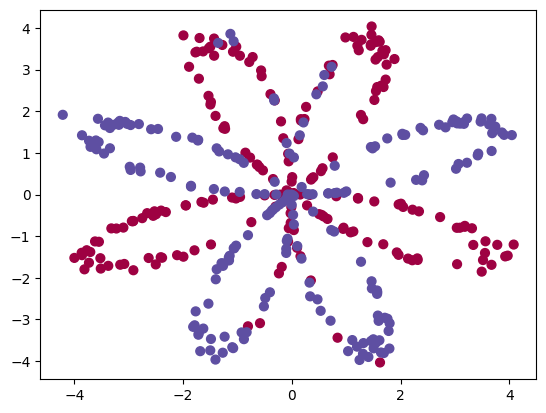

In [12]:
# visualize the dataset
plt.scatter(x[0, :], x[1, :], c=y, s=40, cmap=plt.cm.Spectral)

In [13]:
print(x.shape, y.shape)
print('Training examples', x.shape[1])


(2, 400) (1, 400)
Training examples 400


# 3. Simple Logistic Regression

before bulding a nn, let's see how this logistic reg. would work on it.

In [14]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(x.T, y.T)

c:\python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(pred_func, X, Y):
    # Set min and max values + some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict function value for whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot contour and training points
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=Y.flatten(), cmap=plt.cm.Spectral, edgecolors='k')


Text(0.5, 1.0, 'Logistic Regression')

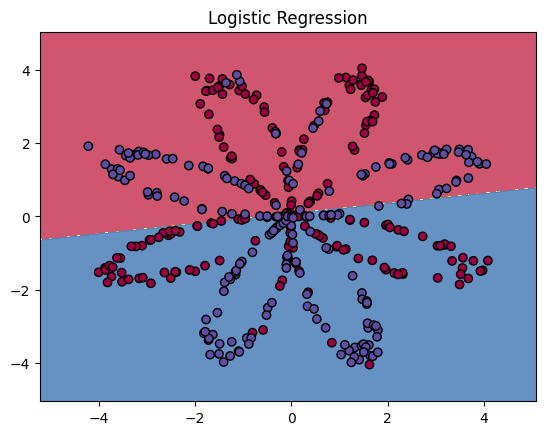

In [16]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), x, y)
plt.title("Logistic Regression")

In [17]:
LR_predictions = clf.predict(x.T)
accuracy = (np.dot(y, LR_predictions.T) + np.dot(1 - y, 1 - LR_predictions.T)) / y.size
print('Accuracy of logistic regression: {:.2f} % (percentage of correctly labelled datapoints)'.format(accuracy.item() * 100))

Accuracy of logistic regression: 47.00 % (percentage of correctly labelled datapoints)


## 4. Neural Network model

### 4.1 Defining the neural network structure:


In [18]:
def layer_sizes(x, y):
    n_x = x.shape[0]
    n_h = 4
    n_y = y.shape[0]

    return (n_x, n_h, n_y)

### 4.2 Initialize the model's parameters:

In [27]:
def initialize(n_x, n_h, n_y):
    w1 = np.random.rand(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    assert (w1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (w2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    params = {'w1': w1,
              'b1': b1,
              'w2': w2,
              'b2': b2}
    
    return params


In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### 4.3 The loop

Implement `forward_propagation()`.
In it retrieve parameters from initialize() function then implement forward propagation to compute z1, a1, z2 and a2 and need to store the values needed in backpropagation in 'cache' which will be returned by this function.

In [29]:
def forward_propagation(x, params):

    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']

    # now calculate probabilities
    z1 = np.dot(w1, x) + b1
    A1 = np.tanh(z1)
    z2 = np.dot(w2, A1) + b2
    A2 = sigmoid(z2)

    assert(A2.shape == (1, x.shape[1]))

    cache = {'z1': z1,
             'A1': A1,
             'z2': z2,
             'A2': A2}
    
    return A2, cache


Now implement `compute_cost()` to get the total cost, using cross-entopy loss.
In it one can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`. Note that if you use `np.multiply` followed by `np.sum` the end result will be a type `float`, whereas if you use np.dot, the result will be a 2D numpy array. We can use `np.squeeze()` to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array). We can cast the array as a type float using `float()`.

In [33]:
def compute_cost(A2, y):
    m = y.shape[1]
    cost = - (1/m) * (np.dot(y, np.log(A2).T) + np.dot(1-y, np.log(1-A2).T))
    cost = float(np.squeeze(cost)) # casting as float type by reducing the dimension

    assert(isinstance(cost, float))

    return cost


Implement `backward_propagation()` this is the most mathemetical part in DL where we use 6 equations (in vectorized form) to update what has been calculated (as there are 4 weights and for them we need our 2 z's to be computed) so..

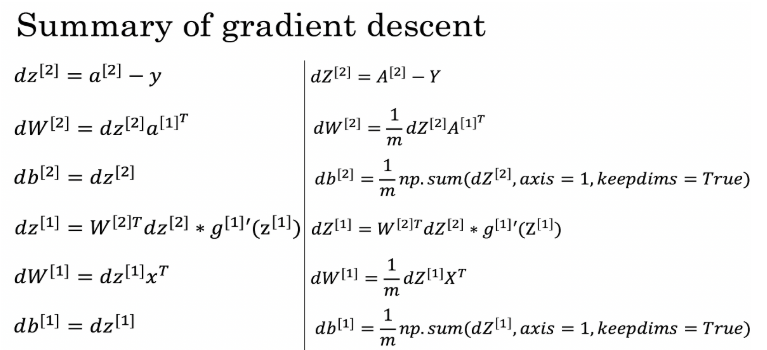

In [23]:
def backward_propagation(params, cache, x, y):
    m = x.shape[1]

    w2 = params['w2']

    A1 = cache['A1']
    A2 = cache['A2']

    dz2 = A2 - y
    dw2 = (1/m) * np.dot(dz2, A1.T)
    db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)
    dz1 = np.dot(w2.T,dz2) * (1 - np.power(A1, 2))
    dw1 = (1/m) * np.dot(dz1, x.T)
    db1 = (1/m ) * np.sum(dz1, axis=1, keepdims=True)

    grads = {'dw1': dw1,
             'db1': db1,
             'dw2': dw2,
             'db2': db2}
    
    return grads

now update the parameters using gradient descent with a good learning rate.

In [24]:
def update_params(params, grads, lr=1.2):
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']

    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']

    w1 = w1 - lr*dw1
    b1 = b1 - lr*db1
    w2 = w2 - lr*dw2
    b2 = b2 - lr*db2

    params = {'w1': w1,
              'b1': b1,
              'w2': w2,
              'b2': b2}
    
    return params

### 4.4 Integrate parts in nn_model() function.
will return the parameters learned by model

In [25]:
def nn_model(x, y, n_h, iters=10000, print_cost=False):
    np.random.seed(42)
    n_x = layer_sizes(x, y)[0]
    n_y = layer_sizes(x, y)[2]

    # now initialize parameters
    params = initialize(n_x, n_h, n_y)

    # now loop of training
    for i in range(iters):
        A2, cache = forward_propagation(x, params)
        cost = compute_cost(A2, y)
        grads = backward_propagation(params, cache, x, y)
        params = update_params(params, grads)

        if print_cost and i % 1000 == 0:
            print(f'Cost after iteration {i}: {cost}')

        
    return params


In [34]:
params = nn_model(x, y, 4, 10000, print_cost=True)
print('w1 = ' + str(params['w1']))
print('b1 = ' + str(params['b1']))
print('w2 = ' + str(params['w2']))
print('b2 = ' + str(params['b2']))

Cost after iteration 0: 0.693191127497264
Cost after iteration 1000: 0.25618650482404864
Cost after iteration 2000: 0.23832340630985305
Cost after iteration 3000: 0.23017687324526037
Cost after iteration 4000: 0.2250975636666336
Cost after iteration 5000: 0.22153025471707302
Cost after iteration 6000: 0.21885512441610314
Cost after iteration 7000: 0.22046299734590086
Cost after iteration 8000: 0.21931163502330372
Cost after iteration 9000: 0.21844783834367262
w1 = [[  9.28488521 -10.23146615]
 [-11.48046899   3.4226415 ]
 [  0.15769855  -9.72083996]
 [ 11.55573601  13.51441109]]
b1 = [[ 0.09116155]
 [-0.3945788 ]
 [-0.09957948]
 [ 0.03538556]]
w2 = [[ 10.57743961   3.45838525 -12.01041473  -6.13778362]]
b2 = [[-0.05421178]]


### 4.5 Predictions:
so using forward proragation to predict
if activation > 0.5 then 1 else 0

In [35]:
def predict(params, x):
    A2, cache = forward_propagation(x, params)
    predictions = (A2 > 0.5)

    return predictions

In [38]:
predicts = predict(params, x)
print("predictions mean = " + str(np.mean(predicts)))

predictions mean = 0.5175


let's plot the graph of how it has performed on the dataset.

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

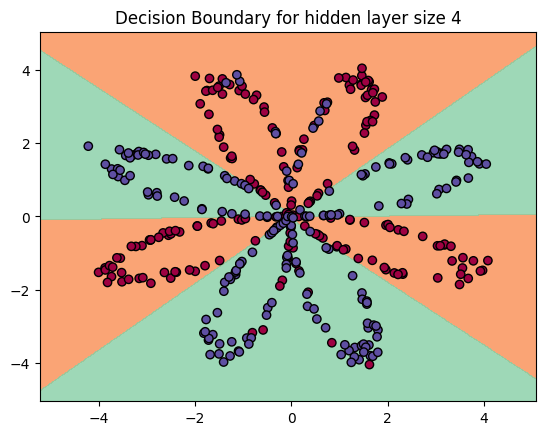

In [39]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(params, x.T), x, y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [40]:
# Print accuracy
predictions = predict(params, x)
print ('Accuracy: %d' % float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100) + '%')


Accuracy: 90%


C:\Users\Naman chanana\AppData\Local\Temp\ipykernel_21384\1946299911.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100) + '%')


### 4.6 Tuning hidden layer size:
now let's try out different hidden layer sizes


C:\Users\Naman chanana\AppData\Local\Temp\ipykernel_21384\2656895608.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100)


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 90.25 %
Accuracy for 20 hidden units: 90.25 %
Accuracy for 50 hidden units: 90.75 %


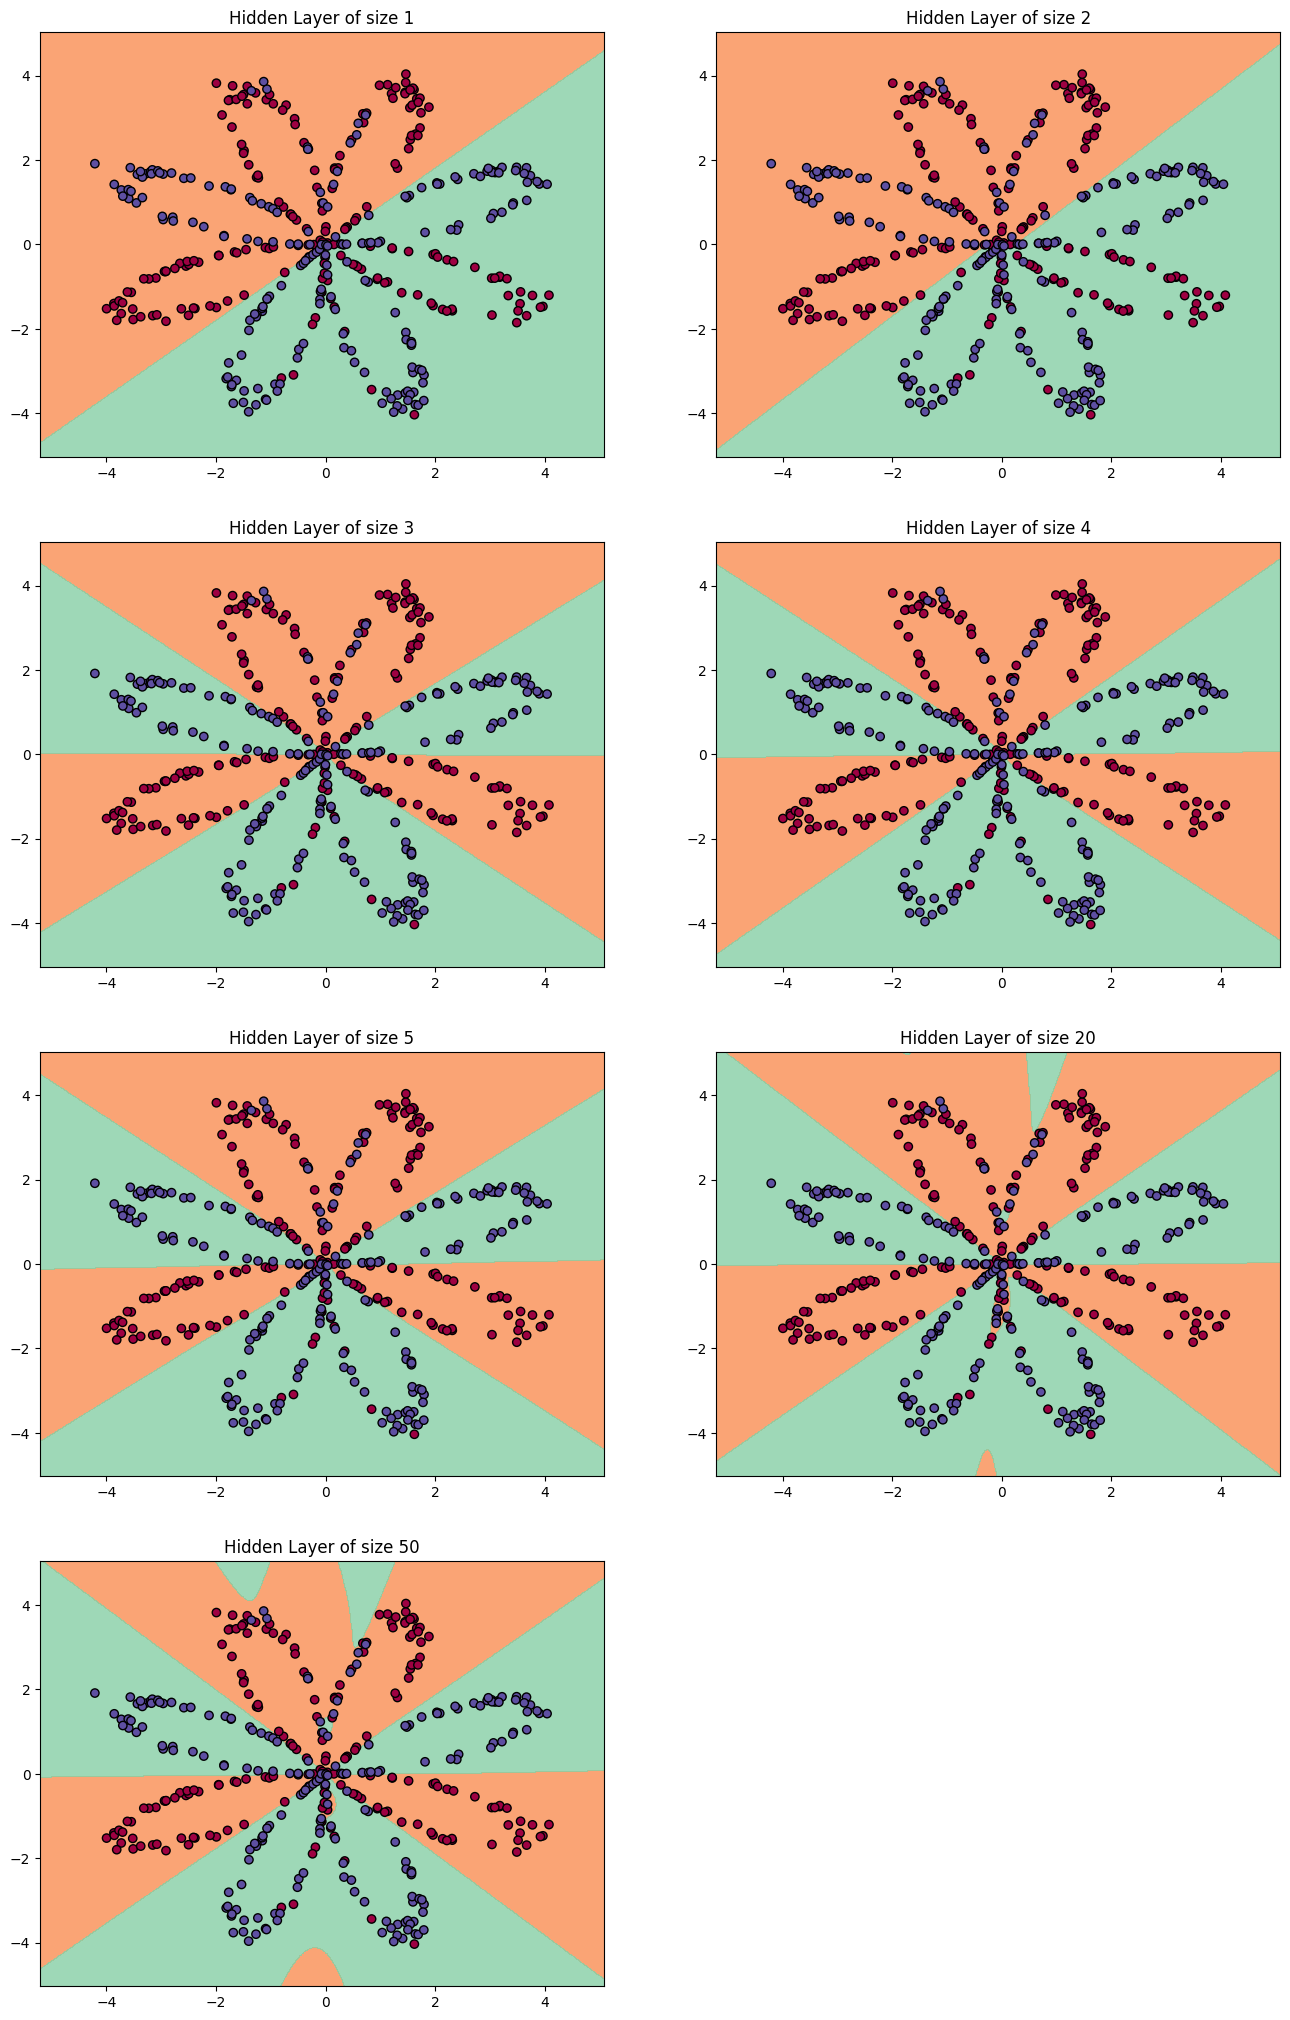

In [42]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(x, y, n_h, iters = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), x, y)
    predictions = predict(parameters, x)
    accuracy = float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

so as the layer-size increases the model performed well untill it started to overfit the data
the size of n_h = 5 (around that) seems to be optimal without any noticable overfitting.


Finish Assignment.